# Current Source Density Analysis 

## How can we highlight local aspects of electrophysiology data in the presence of volume conduction? Can we identify the laminar structure of the auditory cortex given a laminar array of electrodes and auditory stimuli?

Individual neurons act as sources and sinks of current forming dipole moments. Depending on the anatomy of the given brain region being recorded from, neurons are often aligned forming larger cumulative dipoles that are picked up by the recording electrode. If the dipole moment for two neurons are not aligned this can effectively cancel out. Fortunately, cortex has fairly regular laminar structure with many neurons having similar alignments. When a neuron receives input at its dendrites and channels open allowing positively chareged ions in this leads to a negative deflection in the extracellularly recorded potentials (called a current sink), and the extracellular space farther away from this sink will be more positive and will be a source for return current (current source). <i>


<p style="text-align: center;"><img src="images/sources and sinks.png" alt="drawing" width="500"/></p>


The activity at recording electrodes reflects a mixture of local activity and activity from neighboring sources that can propogate via the conductive media of the brain. We want to reduce this volume conducted signal to identify local positive (sources) and negative (sinks) in the LFP signal which can reflect localized neural activity. To address this issue, we can simply take the spatial derivative, the change in voltage per distance, given the known spacing of contact sites. This is typically called current source density analysis when applied to multicontanct probes in the brain and has been used to identify local activity patterns associated with laminar processing. For a more thorough background, see Neuromethods (2012) 67: 205–218 DOI 10.1007/7657_2011_6. 
    
<p style="text-align: center;"><img src="images/laminar_probe_CSD.png" alt="drawing" align="center" width="500"/></p>

We will now go through some of the basic signal processing steps needed to estimate the CSD for laminar probes.

### Function list

Numpy
* `np.sin()
*  np.pi()
*  np.hanning()
*  np.matlib.repmat()

Matplotlib (these are not central to today's presentation but are good to know about). We'll mostly be using plot functions that we already know.
* `plt.colorbar()
*  plt.set_labels()

Scipy
* `scipy.signal.butter()
*  scipy.signal.sosfilt()
*  scipy.signal.convolve2d()

# Load the data


First, import the requisite libraries. You should already have all these installed in your Anaconda environment.

In [174]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import scipy as scipy
import tables as tb
from scipy.signal import convolve2d, butter, sosfilt
import pycurl


## Use pycurl to pull down the data

pycurl is cool and 


In [4]:
with open('data/TAR010a.h5', 'wb') as f:
    c = pycurl.Curl()
    c.setopt(c.URL, 'https://hearingbrain.org/tmp/TAR010a.h5')
    c.setopt(c.WRITEDATA, f)
    c.perform()
    c.close()

### Exercise - load the data

Raw (1500Hz lowpass filtered and downsampled for sake of convenience)- data from a 64 channel silicone probe recording made in ferret primary auditory cortex has been stored in a .hdf5 file in the `data/` subdirectory thanks to the pycurl code above. This is the same general file type as the data from week 4 image processing and can be accessed with the tables module, tb. This file should contain the raw voltage data and epoch timestamps surrounding the stimuli.

Remember, the tb module has a function, open_file, that will let us store a "File" object needed to access the data. Lets load this file and print out the directories so we know where to pull in data from.

In [5]:
#load file
fh = tb.open_file('data/TAR010a.h5')

#print file directories
print(fh)

data/TAR010a.h5 (File) ''
Last modif.: 'Mon Feb  7 16:35:50 2022'
Object Tree: 
/ (RootGroup) ''
/epochs (Array(60, 2)) ''
/probedata (Array(64, 361165)) ''
/stim (Array(60,)) ''



Look at the output of the file above. The file object has a method, `get_node` that returns a node object. This node object provides a method, `read`, that loads the data from disk and returns it as a Numpy array object.

Use the 'get_node' and 'read' functions to load the data into a numpy array object called "probedata'.

In [6]:
# Answer
node = fh.get_node('/probedata')
probedata = node.read()

Check to make sure you've got the right shape

In [7]:
print(probedata.shape)

(64, 361165)


Repeat the above steps to load the data for "epochs" from the file object into a variable called "epochs". Check its shape.

In [9]:
# Answer
node = fh.get_node('/epochs')
epochs = node.read()
print(epochs.shape)

(60, 2)


# Signal processing

Often times, we have data that we know has multiple unique sources in it, noise, or components that are not of interest given a particular question. In extracellular electrophysiology data there are often multiple components we are interested in, AP/spikes - voltage fluctaions on the order of 1-2ms due to fast Na+/K+ channel dynamics and the local field potential (LFP) - thought to primarily reflect slower timescale channels (AMPA/GABA) as well as synchronous spiking near the electrode. Although somewhat arbitrary, we can typically separate these different features of interest by filtering the data. Here we will briefly go over signal filtering which is an important step in many signal processing pipelines.

To demonstrate the basics of signal filtering, lets create two simple signals with different frequency characterstics and then use a filter to separate them again.

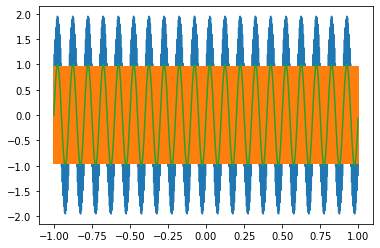

In [10]:
#simulation parameters
freq1 = 10
freq2 = 800
fs = 1000
time = np.arange(-1, 1, 1/fs)

#create signals
signal1 = np.sin(2*np.pi*freq1*time)
signal2 = np.sin(2*np.pi*freq2*time)

#combine signals
combined = signal1 + signal2

#plot combined signal
plt.plot(time, combined)
plt.plot(time, signal2)
plt.plot(time, signal1)

Lets use a filter to separate the two known sources.

A butterworth filter is a commonly used filter that has a flat profile in the pass band, the frequencies that it lets
through won't have amplitude distortions or ringing effects that some other filter kernels create. Scipy has a nice function, scipy.signal.butter(), that lets us design our own butterworth filter.

The major parameters to be considered are the filter order, which is essentially the length of our filter kernel. This parameter specifies length based on a multiple of the the lowest frequency asked for in the cutoff frequency. In general, this should be larger than 3 which is the default. The larger the filter order, the better the filter frequency precision although this comes at a drawback of increased computation time and creates a shift in the phase of the signal (this can be corrected for so it is not a big deal). The other parameters are the cutoff frequencies/passband which specifies the frequencies that we want to filter out of our signal. The next parameter is the filter type (low, high, bandpass). You also need to know the sampling frequency of the signal you wish to filter. One common way to implement a filter is a second order sections method which we implement here.

For more information regarding filters, I'd recommend Mike X Cohens book analyzing neural time series which has a whole chapter devoted to properly designing filters. Additonally, The scientists and engineers guide to digital signal processing is freely available although a bit more dense and less fun https://www.dspguide.com/.

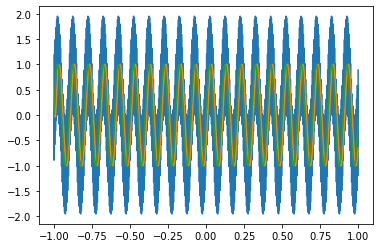

In [11]:
#filter parameters
order = 5
passband = 50

#design filter
sos = scipy.signal.butter(order, passband, 'lowpass', fs=fs, output='sos')

#filter data
signal1filt = scipy.signal.sosfilt(sos, combined)

#plot signals
plt.figure()
plt.plot(time, combined)
plt.plot(time, signal1filt)
plt.plot(time, signal1)

This example is extremely basic, but it shows that our filter can essentialy extract one signal from a combined signal. Which is pretty cool.

### Exercise - Create a filter to isolate the higher frequency signal

Now that you have some experience with filtering, design a filter to extract the high frequency component of the combined signal we generated and save it as "signal2filt". Then plot the first 100 samples of your filter signal and the original high frequency signal. 

In [ ]:
# Answer
order = 5
passband = 50
sos = scipy.signal.butter(order, passband, 'highpass', fs=fs, output='sos')

signal2filt = scipy.signal.sosfilt(sos, combined)

plt.figure()
plt.plot(time[:100], signal2filt[:100])
plt.plot(time[:100], signal2[:100])

### Exercise - Filter raw data to extract the local field potential and the multiunit activty


As stated earlier, the data has been lowpass filtered and downsampled below 1500Hz. This means the signal should contain the low frequency signal neuroscientists typically refer to as the local field potential as well as high frequency spiking related activity although the sampling rate and filter are much too low to identify spike waveforms we will use this activity as a measure of what is typically refered to as multiunit activity or general spike related activity. 

Given our experience with butterworth filters, lets filter the data to create a signal called "mua" that contains data high-pass filtered above 100Hz. It is worth noting that our data currently has multiple dimensions and can be filtered along any of them. We want to filter along the time dimension so we will need to use an additional input in sosfilt to specify the axis we want to filter along.

In [13]:
# Answer
fs = 1500
sos = scipy.signal.butter(4, 100, 'highpass', fs=fs, output='sos')
mua = scipy.signal.sosfilt(sos, probedata, axis=1)


Lets also save the local field potential activity in a variable called "lfp" that is bandpassfiltered between 1 and 150Hz. It is worth noting that our data currently has multiple dimensions and can be filtered along any of them. We want to filter along the time dimension
so we will need to use an additional input in sosfilt to specify the axis we want to filter along.

In [12]:
# Answer
sos = butter(4, [1, 150], 'bandpass', fs=fs, output='sos')
lfp = sosfilt(sos, probedata, axis=1)

Spiking activity has negative and positive deflections and we want to convert this into an amplitude profile for cleaner viewing and interpretation. To do this, we will take the absolute value of the mua signal with numpy's abs function. np.abs(data) will take the absolute value of the input. Try this for the filtered mua. 

In [14]:
# Answer
mua = np.abs(mua)

# Trial averaging the data

Although you can take CSD estimates for individual trials CSD is often estimated on trialized data. We have a list of start and stop times defining trial epochs around an auditory stimulus. The epochs contain a 0.5 second prestimulus silence followed by a tone and post stimulus silence period. The shape of the epochs array is a 60, 2 array. This means we have a start time column and a stop time column and 60 trials.

Subtract the stop times from the start times to determine how long each epoch is. 

In [19]:
# Answer

print((epochs[:, 1] - epochs[:, 0]))


[1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6
 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6
 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6 1.6
 1.6 1.6 1.6 1.6 1.6 1.6]


### Exercise - extracting event data

Given the knowledge about the epochs, lets use the first and last value in each row of the epochs data (the start and end of the trial epoch), to slice out these epochs for both mua and lfp. 

First, lets convert epoch times into samples that we can use for slicing. Given the sampling rate of 1500 samples per second convert the epochs time list to an epochs sample list.

In [20]:
# Answer
epochs = epochs*fs

Now that we have the epochs in samples this should be a simple job to loop through this list of trials, take the start and stop sample for each trial, and slice them out of our longer data structure to generate a list of trial epoched data. Here is how I chose to do this for the lfp signal.

In [21]:
#First, I initialize a matrix that is the size of the expected output. We know there are 60 trials from the epochs list.
#We also know that there are 64 channels of data. Finally, we know that the length of each epoch is 1.6 seconds at 1500hz.

lfp_trials = np.zeros((60, 64, int(1.6*1500)))

#loop through list of trial epochs and for each epoch extract the data within the epoch bounds
for i in range(60):
    lfp_trials[i, :] = lfp[:, round(epochs[i, 0]):round(epochs[i, 1])]
    
#sanity check that data shape is correct
np.shape(lfp_trials)

(60, 64, 2400)

Beautiful. We now have a 60 trial, by 64 channel, by 2400 sample matrix for lfp. Using this same for loop notation, try to extract the data for the mua and save it as "mua_trials".

In [22]:
# Answer

#initialize matrix
mua_trials = np.zeros((60, 64, int(1.6*1500)))

#loop through list of epochs and for each epoch extract 
for i in range(60):
    mua_trials[i, :] = mua[:, round(epochs[i, 0]):round(epochs[i, 1])]
    
#sanity check that data shape is correct
np.shape(mua_trials) 

(60, 64, 2400)

### Exercise - trial average the data

Recall the np.mean() function. We can use this to calculate the trial averaged activity for both our lfp and mua if we specifiy the proper axis. Try taking the mean of this data along the trials axis and save the data into variables "lfp_tavg" and "mua_tavg".

In [135]:
# Answer

lfp_tavg = lfp_trials.mean(axis = 0)
mua_tavg = mua_trials.mean(axis = 0)

Lets now plot the data for one channel to see what it looks like.

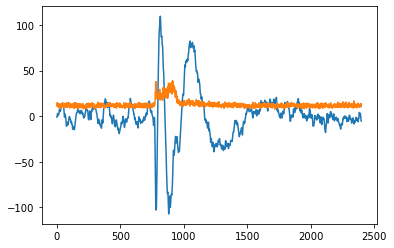

In [136]:
plt.plot(lfp_tavg[0, :])
plt.plot(mua_tavg[0, :])

# Taking a single column of electrodes

The method of CSD estimation that we are using is easiest to implement for uniform grids. The probes in this dataset have an unique arrangement with 3 columns of uniformly spaced electrodes that are 50 microns apart.

![title](images/64chprobe.png)

We'll extract a single uniformly spaced column and estimate the CSD from that.

In [137]:
#Here are the channel numbers for each of the the three columns of electrodes
left_ch_nums = np.arange(3,64,3)-1
right_ch_nums = np.arange(4,65,3)-1
center_ch_nums = np.insert(np.arange(5, 63, 3),obj=slice(0,1),values =[1,2],axis=0)-1

### Excercise - extracting a single column of electrodes from the probe.

The channel maps provided above specify the index values for each channel. Try slicing out the center column of electrodes from the lfp_tavg and mua_tavg data and save as "lfp_tavg_cent" and "mua_tavg_cent". Remember that after trial averaging, we are now left with a 64 channel by 2400 sample matrix. If I wanted to slice out just two channel, channel 0 and 5, I could do this.

In [138]:
two_channels = lfp_tavg[[0, 5], :]

Try slicing out the center column of electrodes from the lfp_tavg and mua_tavg data and save as "lfp_tavg_cent" and "mua_tavg_cent". 

In [139]:
lfp_tavg_cent = lfp_tavg[center_ch_nums, :]
mua_tavg_cent = mua_tavg[center_ch_nums, :]

# Spatial filtering

In this particular case, we are also going to apply a spatial hanning window filter to smooth the data between electrodes. To do this, we generate a hanning window, a tapered cosine function, and by applying this taper across the channels each point becomes a weighted sum of itself and its neighbors that is most heavily weighted towards the center. This should smooth or decrease channel to channel variability that may show up in CSD which emphasizes local differences.

Using np.hanning we can create a hanning window to use to smooth our data. np.hanning takes one input which determines the number of samples used
#to create the window. Here is a 30 sample point hanning window.

(30, 1)

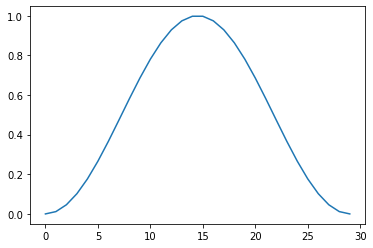

In [140]:
spatial_filter = np.hanning(30)[:, np.newaxis]

plt.plot(spatial_filter)
np.shape(spatial_filter)

 We will use 5 for our window size for the actual analysis, which will mean we are estimating each electrode given one contact on either side.

2.0

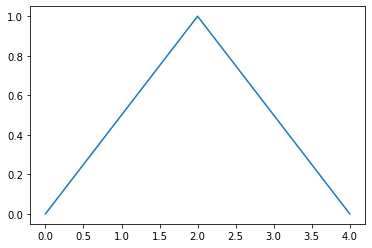

In [141]:
spatial_filter = np.hanning(5)[:, np.newaxis]

plt.plot(spatial_filter)

np.sum(spatial_filter)

Note the sum of the signal is more than 1. If we are multipling each point of the hanning window by an electrode to scale it and then taking the sum of these 5 scaled points/electrodes we will be amplifying our signal. We can properly scale this by normalizing our spacial filter to equal 1. 

1.0

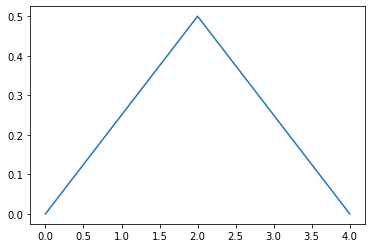

In [142]:
spatial_filter = spatial_filter / spatial_filter.sum()

plt.plot(spatial_filter)
np.sum(spatial_filter)

We will convolve our hanning filter along our data in the channel dimension. Convolution is a sliding dot product, which will take the five points in our hanning window (0, 0.25, 0.5, 0.25, 0) and multiply each of these values by an electrode voltage value prior to taking the sum of these weighted voltage values as the output. This window will slide along our channel columns smoothing it in the spatial dimension.

In [143]:
#convolution will take the sliding dot product of our filter with our data which smooths the data by estimating each point as the weighted sum of its neighbors.
CSD_formatted = convolve2d(lfp_tavg_cent, spatial_filter, mode='same', boundary='symm')

# Current source density algorithm - estimating the second spatial derivative

The second spatial derivative is often approximated by a three point formula involving taking the difference in voltage over space between two pairs of points - (voltage(x + some distance) - voltage(x)) - ((voltage(x) - voltage(x - some distance)). This is then normalized by the square of the distance - (some distance)^2. The distance chosen is a parameter that can vary and may impact the spatial resolution of identified sources and sinks. In the example from Higley, Neuromethods (2020), delta v is 200 microns as they choose to skip the nearest contact site in a probe with 100 micron spacing. This value may vary depending on your recording setup and anatomical considerations. Here we will just set the distance to one contact site.

<p style="text-align: center;"><img src="images/CSD equation.png" alt="drawing" width="500"/></p>


From the above equations, it should be apparrent that we will not be able to estimate the CSD at top or bottom electrode because we don't have a point above or below these electrodes respectively to perform the calculation. Although dubious, it is often the case that groups will extend/duplicate the data from the top and bottom electrodes under the assumption that the voltage recorded at nearby electrodes is not drastically different and therefore will not greatly impact the estimation. We will avoid doing this here and will simply lose data on both of these channels.

We can convert the equation from up above into code with the channel spacing, detla V, set to 50 microns. Also instead of skipping the neighboring site in our estimation lets use the nearest neighbor. Normalize by the square of the delta V.

In [144]:
#delta z
ch_spacing = 50

#defining electrode sites for the 3 point equation

V0 = CSD_formatted[0 + 1, :] # voltage at the site we want to estimate at
Va = CSD_formatted[0, :]     # voltage at the site above
Vb = CSD_formatted[0 + 2, :] # voltage at the site below

#estimate the CSD at one site with the 3 point equation

CSD_est = (Vb + Va - 2*V0)/(ch_spacing)**2

### Excercise - initialize an output matrix for CSD

This only takes the voltage value at one site. We want to calculate this value for all the channels except for the top and bottom most electrodes which can't be estimated at because we don't know the voltage value above or below these points. This can be done by simply placing the code above in a for loop. Lets start by creating a matrix of the expected output size called CSD_est that is full of zeros. What is the expected output size if we drop two channels?

Go ahead and try to do this yourself. 

In [145]:
# Answer

CSD_est = np.zeros_like(lfp_tavg_cent[:20, :])

### Excercise - Using a for loop, compute CSD at all electrode positions

Try to create a for loop to fill the matrix we just created. This should be simply copying the triple point CSD equation code and pasting it into a for loop with a proper number of iterations specified and changing the slicing to account for our looping variable.

In [146]:
# Answer

#loop through each channel and estimate the CSD along the time dimension
for i in range(0, len(lfp_tavg_cent) -2):
    V0 = CSD_formatted[i + 1, :]
    Va = CSD_formatted[i, :]
    Vb = CSD_formatted[i + 2, :]
    CSD_est[i, :] = (Vb + Va - 2*V0)/(ch_spacing)**2

Plotting of CSD is often done with the sign of values flipped so that sinks appear as positive and sources appear negative. Lets quickly do this for the sake of being normal.

In [147]:
#flip sign of CSD for plotting purposes
CSD_est = -CSD_est

# Plot the estimated CSD

Time to use plt.imshow() to plot the CSD_est we just generated! Remember, imshow defaults to the origin being in the upper right which has be corrected with an additional parameter. Also, in this case, the units of the x and y axis are not the same so we have to adjust the aspect ratio to keep the axes fixed as this parameter defaults to 1 as it assumes we want square pixels as in images. Note we also use the cmap parameter to change the color map used for plotting.

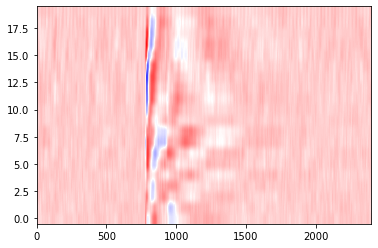

In [148]:
plt.figure()
plt.imshow(CSD_est, origin = 'lower', aspect = 'auto', cmap = 'bwr')

This looks good. However, we are plotting more data than necessary. The majority of the interesting components happen right around sample 750. This corresponds to the stimulus following a 0.5 second delay. Lets look at 0.05 seconds prestimulus and 0.15 seconds poststimulus. Try to slice and plot the data around this timeframe to see if it looks better.

### Exercise - zooming in on stimulus window

In [149]:
# Answer
stim = 750

prestim = stim - int((0.05*fs))
poststim = stim + int((0.15*fs))

CSD_est = CSD_est[:, prestim:poststim]



Now, try replotting the CSD_est, but this time also adjust the axis with the 'extent' parameter of imshow to properly scale the y axis to reflect distance and x axis to reflect the new time window we are focusing on. Also take the time to use plt.xlabel, and plt.ylabel to properly label the axis.

Text(0, 0.5, 'Position from recording tip (microns)')

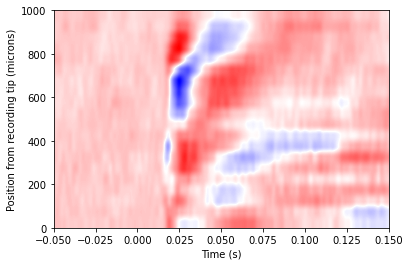

In [150]:
# Answer
plt.figure()
plt.imshow(CSD_est, extent = [-.05, .15, 0, 1000], origin = 'lower', aspect = 'auto', cmap = 'bwr')
plt.xlabel("Time (s)")
plt.ylabel("Position from recording tip (microns)")

Let's also plot a colorbar so we can determine the magnitude of the CSD values. Use plt.colorbar to produce a color bar and save this object to a variable called cbar. Once set as an object, we can use the .set_label method on cbar to label colorbar. Set this label to "CSD uV/um^2"

Text(0, 0.5, 'Position from recording tip (microns)')

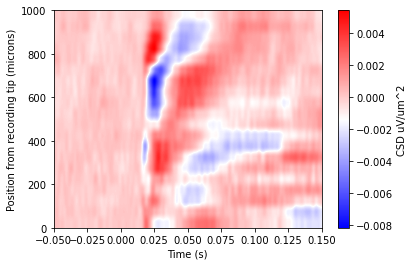

In [151]:
# Answer
plt.figure()
plt.imshow(CSD_est, extent = [-.05, .15, 0, 1000], origin = 'lower', aspect = 'auto', cmap = 'bwr')
cbar = plt.colorbar()
cbar.set_label("CSD uV/um^2")
plt.xlabel("Time (s)")
plt.ylabel("Position from recording tip (microns)")

Great! But what, if anything, do these stimulus evoked sources and sinks tell us about neuroanatomy? Here is a bit of what is known about auditory evoked CSDs.

"Noise-evoked columnar CSD patterns were used to determine the location of the A1 recording channel. Two CSD signatures were
used to identify L4: A brief current sink first occurs approximately 10 ms after the noise onset, which was used to determine the lower
border of L4 (Kaur et al., 2005). A triphasic CSD pattern (sink-source-sink from upper to lower channels) occurs between 20 ms and
50 ms, where the border between the upper sink and the source was used to define the upper boundary of L4. Normally, 2 channels
were assigned to L4. Other layers were defined relative to the location of L4 (L2/3: 3 channels above L4; L5: 3 channels below L4; L6: 3
channels below L5). CSD-derived layer assignments were cross-validated against sound-evoked MUA response patterns, where L4
and L5 units responded with higher firing rates and shorter latency."
(Guo et al 2017)

Given this knowledge, lets place a vertical line on our plot at 10ms which should be near the first sink in the signal and might help visualize it. Recall that we can use axvline.

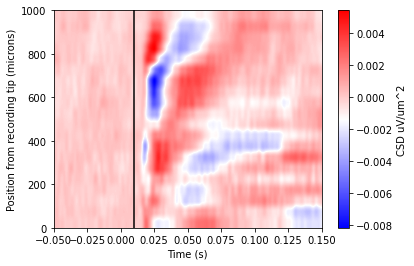

In [152]:
# Answer
ch_map = np.arange(0, 20*50, 50)
plt.figure()
plt.imshow(CSD_est, extent = [-.05, .15, 0, 1000], origin = 'lower', aspect = 'auto', cmap = 'bwr')
cbar = plt.colorbar()
cbar.set_label("CSD uV/um^2")
plt.xlabel("Time (s)")
plt.ylabel("Position from recording tip (microns)")
plt.axvline(x = 0.01, color = 'k', label = 'axvline - full height')

### Excercise - adding in MUA

Almost done! Finally, as stated above in the pre-existing knowledge about auditory CSDs, we might expect overlaying the multiunit activity to provide a bit more insight. Lets do that since we took the time to filter our and process the mua. 

To start, we need to separate the mua values from one another - they are all around the same voltage so if we just plotted them they'd all be on top of each other for each channel. Perhaps the simplest thing to do, since the background mua is relatively close to 0, is to add the channel distance to all the values from that channel so they are all evenly spaced apart. 

Lets start by creating a list of channel spacings for all 20 channels in increments of 50. Try to use np.arange() to do this.

In [205]:
# Answer 
ch_distance = np.arange(0, 20*50, 50)

Next, lets try to add the corresponding distance value from the list of spacings we just generated to each sample value for that channel. This will offset all of our channels from one another by 50 microns. We can use np.repeat to repeat the spacing value from our channel distance list to create an array of equal size to the length of our CSD estimate values for that channel. Below is an example one electrode.

In [206]:
#First, lets slice it around the stimulus so it matches our CSD plot and drop the top and bottom channel.
mua_spacing = mua_tavg_cent[1:21, prestim:poststim]


Now, lets convert our ch_distance array into a column array. This can be done by adding np.newaxis as a dimension when we save it.

In [207]:
ch_distance = ch_distance[:, np.newaxis]

This channel spacing is now in the same orientation as our channels in our mua data. If we replicate this matrix until it is the length of our time dimension, we could add all these channel spacings to the mua. np.matlib.repmat(), is a function that as the name implies allows us to replicate a matrix as many times as we want. Try to replicate the ch_distance matrix so it is the same dimensions as our mua_spacing matrix. Then add it to the mua_spacing matrix to space all the channels evenly.

In [209]:
# Answer
ch_dist = np.matlib.repmat(ch_distance, 1, len(mua_spacing[0, :]))
mua_allspaced = mua_spacing + ch_dist

Now, lets finally add this mua data to our previous plot. You should be able to copy and paste the plotting from the earlier plot and add an additional plt function within a for loop to plot each channel of spaced mua. 

Text(0, 0.5, 'Position from recording tip (microns)')

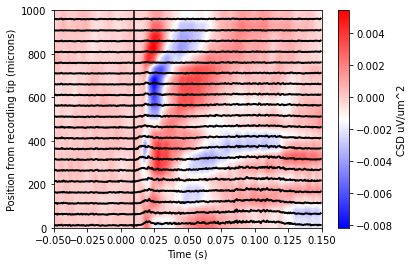

In [211]:
# Answer

time = np.arange(-0.05, 0.15, 1/fs)
plt.figure()
plt.imshow(CSD_est, extent = [-.05, .15, 0, 1000], origin = 'lower', aspect = 'auto', cmap = 'bwr')
cbar = plt.colorbar()
cbar.set_label("CSD uV/um^2")
for i in range(len(mua_allspaced)):
    plt.plot(time, mua_allspaced[i, :], linewidth = 2, color = 'k')
plt.axvline(x = 0.01, color = 'k', label = 'axvline - full height')
plt.xlabel("Time (s)")
plt.ylabel("Position from recording tip (microns)")